This notebook is designed as one's first machine learning experiment. We will load and visualize a dataset of human heights and weights, and use a simple model to predict weight from height.

**After you've familiarized yourself with this notebook, try to modify it as follows:**
* Easy: predict height from weight
* Harder: Add data normalization: subtract the mean and divide by standard deviation. You can use Numpy's mean and std functions. This will greatly improve optimization speed, because the initial network weight are much closer to optimal. It's a good rule of thumb that a neural network's inputs should have approximately zero mean and unit standard deviation.

*Model solutions can be found in [this notebook](MyFirstMachineLearningModel_solutions.ipynb).*

Let's start by including some basic utilities. Most of the time, you're going to need Numpy, PyPlot, and Tensorflow or PyTorch. We also import Keras because it makes building and training basic neural networks easy.

For a bit more complex but similar example, see https://www.tensorflow.org/tutorials/keras/basic_classification

In [1]:
import numpy as np
import matplotlib.pyplot as pp
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #disable Tensorflow GPU usage, a simple example like this runs faster on CPU
import tensorflow as tf
from tensorflow import keras  

Now, let's load some data to process. We'll use the human height and weight dataset from Kaggle, which is in .csv format. This is a common and perhaps the most simple data format -- try opening it in a text editor. Loading .csv using Numpy is easy.

Note that we skip one row which has the headers, and we only extract the second and third column (the usecols argument uses zero-based indexing).

In [2]:
data=np.loadtxt("data/weight-height.csv",skiprows=1,usecols=(1,2),delimiter=",")
print(data)

[[ 73.84701702 241.89356318]
 [ 68.78190405 162.31047252]
 [ 74.11010539 212.74085556]
 ...
 [ 63.86799221 128.47531878]
 [ 69.03424313 163.85246135]
 [ 61.94424588 113.64910268]]


When printing the data, we see that it is a 2D-array or 'tensor'. Machine learning typically utilizes tensors to store and manipulate data. Numpy is the basic package for manipulating tensors on the CPU, and Tensorflow and PyTorch allow one to do the same on the GPU, with some additional features.

** IMPORTANT: Becoming fluent in thinking and coding with tensors takes time but is extremely vital.** 

Let's investigate the data a bit more.

For example, each tensor has a shape: an 1D array that tells about the tensor dimensions. We can also query the number of dimensions with ndim(). The number of dimensions is also called the "rank" of the tensor. In linear algebra terms, a scalar is a rank-0 tensor, a vector is a rank-1 tensor, and a matrix is a rank-2 tensor.

However, in Numpy and Tensorflow, A\*B multiplies the tensors A and B elementwise, and if A and B are vectors, one can use np.dot(A,B) to compute the dot product.

In [3]:
print("Data shape ",data.shape,", dimensionality ",np.ndim(data))

Data shape  (10000, 2) , dimensionality  2


In other words, there's 10000 data points, each with 2 values. The tensor is a 2D one. In this dataset, the first value is height and the second is weight.

Numpy allows very flexible indexing of tensors. One can define exact indexes or use ":" to denote all indexes along a dimension. As an example, let's do some unit conversion: The height values are in inches, and we can multiply them with 2.54 to convert them to meters:

In [4]:
data[:,0]*=2.54  #Here, we use the *= shorthand, which is the same as data[:,0]=data[:,0]*2.54
print(data)

[[187.57142322 241.89356318]
 [174.70603628 162.31047252]
 [188.2396677  212.74085556]
 ...
 [162.22470022 128.47531878]
 [175.34697755 163.85246135]
 [157.33838453 113.64910268]]


Note: if you run the code above for many times, you keep multiplying the height, as Jupyter maintains the program state. You can run the data loading code above to reset the data tensor back to the original value.

Let's now do the same scaling for weight, which is given in pounds.

In [5]:
data[:,1]*=0.45359237
print(data)

[[187.57142322 109.72107461]
 [174.70603628  73.62279191]
 [188.2396677   96.49762887]
 ...
 [162.22470022  58.27542433]
 [175.34697755  74.32222627]
 [157.33838453  51.55036583]]


Now, let's try some data visualization using PyPlot.

Text(0, 0.5, 'Weight (kilograms)')

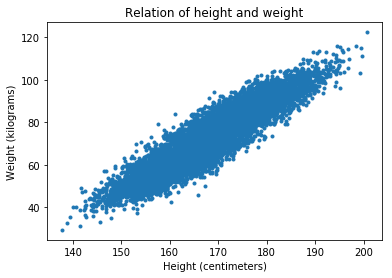

In [6]:
pp.figure(1)
pp.scatter(data[:,0],data[:,1],marker=".")
pp.title("Relation of height and weight")
pp.xlabel("Height (centimeters)")
pp.ylabel("Weight (kilograms)")

Not surprisingly, there's a strong correlation between height and weight. We can see that a 2m tall person typically weights around 110 kg. 

Now, if we want to make such predictions computationally, we're going to need a machine learning model. We will first train a single-neuron network, i.e., a simple linear model. 

In [7]:
#keras.Sequential makes it easy to compose a neural network models out of layers
model = keras.Sequential()

#Add a 1-neuron layer with linear activation, taking one input value. 
#The input_shape=(1,) defines that there's only a single input value, but batch size is yet unknown.
#Note that this notation is a bit misleading, as the batch data index dimension is really the first one and not the second one.  
#Fortunately, the input_shape needs to only be specified for the first layer
model.add(keras.layers.Dense(1,input_shape=(1,),use_bias=True))

#Make the model ready for optimization using Adam optimizer (the usual reasonable first guess).
#The loss parameter defines the loss function that optimization tries to minimize, in this case
#the mean squared error between the network outputs and actual data values.
#The lr parameter is the "learning rate". With this simple model, we can use a high learning rate of 0.1,
#whereas many complex networks require 0.001 or even 0.0001. This makes training more stable but also more slow.
model.compile(optimizer=keras.optimizers.Adam(lr=0.1),loss="mean_squared_error")

#Define our training inputs and outputs. Our network takes in height (column 0 in the data) and outputs weight (column 1).
trainingInputs=data[:,0]
trainingOutputs=data[:,1]

#Reshape the tensors: This is needed because Tensorflow and Keras models expect to get data in batches, as specified above.
trainingInputs=np.reshape(trainingInputs,[trainingInputs.shape[0],1])
trainingOutputs=np.reshape(trainingOutputs,[trainingOutputs.shape[0],1])

#Fit the model. Epochs defines how many times the network will see all data during the training.
model.fit(trainingInputs,trainingOutputs,verbose=1,epochs=5)


Epoch 1/5
10000/10000 [==============================] - 1s 57us/step - loss: 3157.8012
Epoch 2/5
10000/10000 [==============================] - 0s 24us/step - loss: 118.1119 - ETA: 0s - loss: 118.1826
Epoch 3/5
10000/10000 [==============================] - 0s 23us/step - loss: 117.94

Now, let's plot the data again, adding the model predictions.

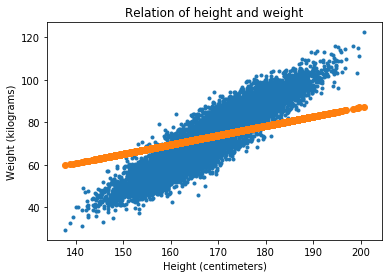

In [8]:
pp.figure(1)
#pp.scatter(data[:,0],data[:,1],marker=".")
pp.scatter(trainingInputs[:,0],trainingOutputs[:,0],marker=".")
pp.title("Relation of height and weight")
pp.xlabel("Height (centimeters)")
pp.ylabel("Weight (kilograms)")
predictions=model.predict(trainingInputs)
#NOTE: The predictions is of the same shape as trainingOutputs, i.e., [10000,1]
#scatter() expects 1-dimensional x and y arrays; thus, we need to use the [:,0] and [:,1] indexing.
pp.scatter(trainingInputs[:,0],predictions[:,0])

What you should see above is a line that predicts growing weight with growing height, but it does not yet fit the data really well. However, the fit gets better when the training continues. Below, we optimize for 50 more epochs and then visualize again. 

Epoch 1/50
 - 0s - loss: 115.6874
Epoch 2/50
 - 0s - loss: 115.5115
Epoch 3/50
 - 0s - loss: 114.1112
Epoch 4/50
 - 0s - loss: 112.2813
Epoch 5/50
 - 0s - loss: 110.8665
Epoch 6/50
 - 0s - loss: 108.9660
Epoch 7/50
 - 0s - loss: 107.2746
Epoch 8/50
 - 0s - loss: 104.6932
Epoch 9/50
 - 0s - loss: 103.6156
Epoch 10/50
 - 0s - loss: 102.2273
Epoch 11/50
 - 0s - loss: 98.7705
Epoch 12/50
 - 0s - loss: 92.2656
Epoch 13/50
 - 0s - loss: 91.1480
Epoch 14/50
 - 0s - loss: 87.6206
Epoch 15/50
 - 0s - loss: 86.7297
Epoch 16/50
 - 0s - loss: 80.4264
Epoch 17/50
 - 0s - loss: 76.6321
Epoch 18/50
 - 0s - loss: 75.4742
Epoch 19/50
 - 0s - loss: 74.2170
Epoch 20/50
 - 0s - loss: 73.5156
Epoch 21/50
 - 0s - loss: 69.9867
Epoch 22/50
 - 0s - loss: 66.5973
Epoch 23/50
 - 0s - loss: 65.6584
Epoch 24/50
 - 0s - loss: 62.2860
Epoch 25/50
 - 0s - loss: 61.5626
Epoch 26/50
 - 0s - loss: 60.6025
Epoch 27/50
 - 0s - loss: 57.1956
Epoch 28/50
 - 0s - loss: 54.6859
Epoch 29/50
 - 0s - loss: 55.4883
Epoch 30/50
 

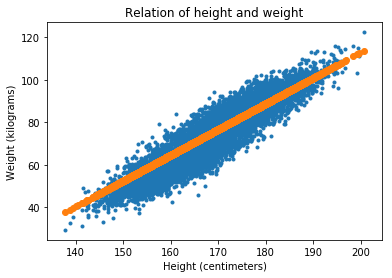

In [9]:
#fit the model
model.fit(trainingInputs,trainingOutputs,verbose=2,epochs=50)  #we predict column 1 from column 0 

#visualize the data
pp.figure(1)
pp.scatter(data[:,0],data[:,1],marker=".")
pp.title("Relation of height and weight")
pp.xlabel("Height (centimeters)")
pp.ylabel("Weight (kilograms)")
predictions=model.predict(trainingInputs)
pp.scatter(trainingInputs[:,0],predictions[:,0])

Now, it's easy to query the model with any height values:

In [10]:
print("The predicted weight for a person who weighs 200kg is ",model.predict([[200]])[0,0])

The predicted weight for a person who weighs 200kg is  113.035934


Note that above, we had to use [[200]], because we only had one value to predict but the network wants a 2D tensor as input. [[200]] defines an array of shape [1,1] with the only element having indices [0,0] and value 200. Similarly, the prediction is a [1,1] shaped tensor, which we query with indices [0,0].

**Unfortunately, this tensor indexing mess is one of the biggest hurdles in getting into ML coding. Don't worry, it's hard for everyone at first. Once you've wrapped your head around it, things will get much easier.**